In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Chargement des données
df = pd.read_csv('../HR_Analytics_Structure_Complet.csv')

print("Données chargées. Taille :", df.shape)
# Aperçu de la cible
print("Répartition de la cible 'Attrition_Numeric' (0=Reste, 1=Départ) :")
print(df['Attrition_Numeric'].value_counts(normalize=True))

Données chargées. Taille : (1356, 34)
Répartition de la cible 'Attrition_Numeric' (0=Reste, 1=Départ) :
Attrition_Numeric
0    0.828909
1    0.171091
Name: proportion, dtype: float64


In [10]:
# 1. Sélection des features (On exclut les colonnes inutiles)
# Attrition_Numeric est notre cible (Target)
# On ne garde que les colonnes existantes à supprimer (Cible + ID)
X_raw = df.drop(['Attrition', 'Attrition_Numeric', 'EmployeeNumber'], axis=1)
y = df['Attrition_Numeric']

# 2. Encodage One-Hot (Transformation des textes en chiffres)
X_encoded = pd.get_dummies(X_raw, drop_first=True)

# 3. Normalisation (Scaling)
# Crucial pour la Régression Logistique pour que les coefficients soient comparables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# On remet en DataFrame pour garder les noms de colonnes (utile pour l'interprétation)
X = pd.DataFrame(X_scaled, columns=X_encoded.columns)

# Sauvegarde des colonnes pour la fonction de prédiction future
features_columns = X_encoded.columns.tolist()

print("--- Préparation terminée ---")
print(f"Nombre de features après encodage : {X.shape[1]}")

--- Préparation terminée ---
Nombre de features après encodage : 45


In [11]:
# Stratify=y assure qu'il y a la même proportion de départs dans le Train et le Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Split terminé.")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Split terminé.
Train shape: (1084, 45)
Test shape: (272, 45)


In [12]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

print("Modèle Naïve Bayes entraîné.")

Modèle Naïve Bayes entraîné.


 RÉSULTATS : NAÏVE BAYES
              precision    recall  f1-score   support

           0       0.93      0.23      0.36       225
           1       0.20      0.91      0.33        47

    accuracy                           0.35       272
   macro avg       0.56      0.57      0.35       272
weighted avg       0.80      0.35      0.36       272



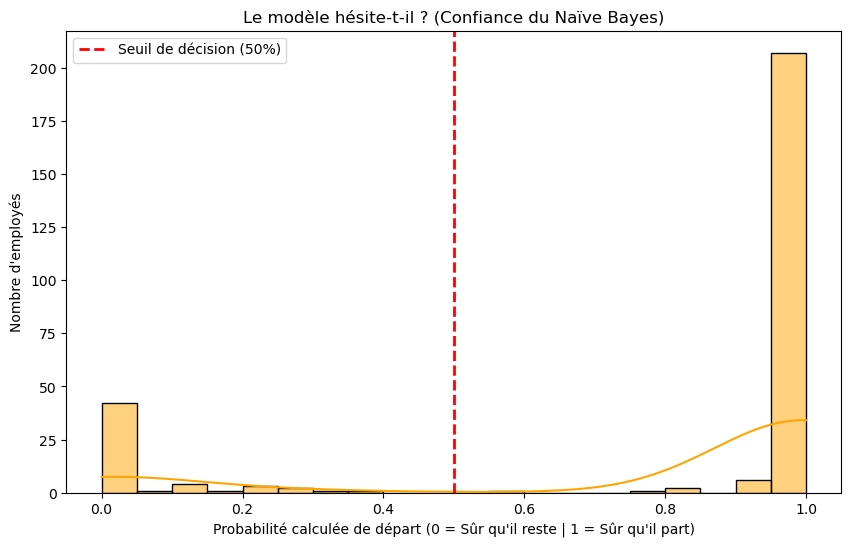

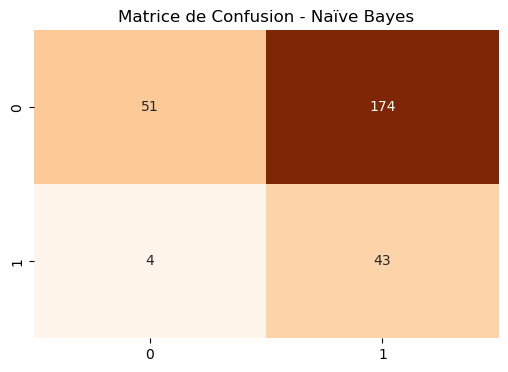

In [18]:
# Cellule 5 : Évaluation & Histogramme de Confiance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("="*40)
print(" RÉSULTATS : NAÏVE BAYES")
print("="*40)
print(classification_report(y_test, y_pred))

# --- GRAPHIQUE : Distribution des Probabilités ---
plt.figure(figsize=(10, 6))
# On dessine la répartition des scores donnés par le modèle
sns.histplot(y_prob, bins=20, kde=True, color='orange', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label="Seuil de décision (50%)")

plt.title("Le modèle hésite-t-il ? (Confiance du Naïve Bayes)")
plt.xlabel("Probabilité calculée de départ (0 = Sûr qu'il reste | 1 = Sûr qu'il part)")
plt.ylabel("Nombre d'employés")
plt.legend()
plt.show()

# Matrice
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("Matrice de Confusion - Naïve Bayes")
plt.show()

Dans ce cas, l'histogramme orange est fascinant. Au lieu d'avoir une distribution étalée, nous voyons un pic massif complètement à droite (vers 1.0). Cela montre que le modèle est "paniqué" : il calcule des probabilités de départ extrêmement fortes pour la quasi-totalité des employés. C'est la signature visuelle d'un modèle biaisé qui génère énormément de Faux Positifs (d'où sa précision catastrophique de 20%).

In [14]:
def predire_demission(input_data, model, scaler, model_columns):
    """
    Simule une prédiction pour un nouvel employé.
    """
    # 1. Création DataFrame
    input_df = pd.DataFrame([input_data])
    
    # 2. Encodage (Get Dummies)
    input_encoded = pd.get_dummies(input_df)
    
    # 3. Alignement des colonnes (Ajout des colonnes manquantes avec 0)
    input_encoded = input_encoded.reindex(columns=model_columns, fill_value=0)
    
    # 4. Scaling (Utilisation du scaler entraîné)
    input_scaled = scaler.transform(input_encoded)

    # On remet les données dans un DataFrame avec les noms
    input_scaled_df = pd.DataFrame(input_scaled, columns=input_encoded.columns)
    
    # 5. Prédiction (Probabilité)
    proba = model.predict_proba(input_scaled_df)[0][1] # Proba de la classe 1 (Départ)
    prediction = "Va Partir (Risque Élevé)" if proba > 0.5 else "Va Rester"
    
    return prediction, proba


In [15]:
# --- TEST ---
profil_employe = {
    'Age': 29,
    'DailyRate': 400,
    'DistanceFromHome': 25, # Loin
    'EnvironmentSatisfaction': 1, # Très insatisfait
    'JobSatisfaction': 1, # Très insatisfait
    'OverTime': 'Yes', # Heures supp
    'Department': 'Sales',
    'JobRole': 'Sales Executive'
}

resultat, proba = predire_demission(profil_employe, model, scaler, features_columns)

print(f"Profil Test : {profil_employe}")
print(f"Résultat : {resultat}")
print(f"Probabilité de départ : {proba:.2%}")

Profil Test : {'Age': 29, 'DailyRate': 400, 'DistanceFromHome': 25, 'EnvironmentSatisfaction': 1, 'JobSatisfaction': 1, 'OverTime': 'Yes', 'Department': 'Sales', 'JobRole': 'Sales Executive'}
Résultat : Va Partir (Risque Élevé)
Probabilité de départ : 100.00%


In [16]:
artefacts = {'model': model, 'scaler': scaler, 'features': features_columns}
joblib.dump(artefacts, '../Models/modele_classif_bayes.pkl')
print("Modèle Bayes sauvegardé.")

Modèle Bayes sauvegardé.


Conclusion :

 Naïve Bayes Ce modèle est très rapide mais fait l'hypothèse que toutes les variables sont indépendantes, ce qui est rarement le cas dans les RH (ex: Salaire et Niveau de poste sont liés).